In [6]:
import json
import pandas as pd
import os
import re
import spacy
import wikipediaapi
import requests
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import ollama
from collections import Counter


input_json_path = "/Users/sristidakshit/Documents/Coursework/Spring25/NLPproject/dtagermanpoetrycorpusfull.json"  # 👈 Update this
output_csv_path = "dlk_poems.csv"

nlp = spacy.load("en_core_web_sm")
wiki = wikipediaapi.Wikipedia(user_agent='dlk_metadata_script/1.0')
embedder = SentenceTransformer('all-MiniLM-L6-v2')

with open("countries.txt") as f:
    countries = [c.strip().upper() for c in f if c.strip()]

with open("cities.txt") as f:
    cities = [c.strip().upper() for c in f if c.strip()]
    
with open('global_themes.txt', 'r') as file:
    allowed_themes = [line.strip() for line in file.readlines()]

location_cache = {}


def extract_poem_text(poem_obj):
    lines = []
    for stanza in poem_obj.values():
        for line in stanza.values():
            line_text = line.get("text", "")
            lines.append(line_text)
    return "\n".join(lines)

def extract_location_from_booktitle(booktitle):
    if not booktitle:
        return None
    match = re.search(r'([A-Za-zÄÖÜäöüß\s]+),\s*\[?\d{4}\]?', booktitle)
    if match:
        return match.group(1).strip()
    return None

def get_location_from_wikipedia(author_name):
    key = author_name.lower()
    if key in location_cache:
        return location_cache[key]

    page = wiki.page(author_name)
    if not page.exists():
        location_cache[key] = "unavailable"
        return "unavailable"

    doc = nlp(page.text)
    places = [
        ent.text for ent in doc.ents
        if ent.label_ == "GPE" and ent.text.upper() not in countries and ent.text.upper() in cities
    ]

    if places:
        most_common = Counter(places).most_common(1)[0][0]
        location_cache[key] = most_common
        return most_common
    else:
        location_cache[key] = "unavailable"
        return "unavailable"
    
GLOBAL_THEME_MAPPING = {
    # Nature & Environment
    "Nature": "Nature & Environment",
    "& Streams": "Nature & Environment",
    "Animals": "Nature & Environment",
    "Rivers": "Nature & Environment", 
    "Seas": "Nature & Environment",
    "Trees & Flowers": "Nature & Environment",
    "Weather": "Nature & Environment",
    "Planets": "Nature & Environment",
    "Heavens": "Nature & Environment",
    "Stars": "Nature & Environment",
    "Landscapes & Pastorals": "Nature & Environment",
    
    # Life & Living
    "Life": "Life & Living",
    "Living": "Life & Living",
    "Life Choices": "Life & Living",
    "Human Experience": "Life & Living",
    "Coming of Age": "Life & Living",
    "Growing Old": "Life & Living",
    "Youth": "Youth & Coming of Age",
    
    # Love & Relationships
    "Love": "Love & Relationships",
    "Relationships": "Love & Relationships",
    "Break-ups & Vexed Love": "Love & Relationships",
    "Men & Women": "Love & Relationships",
    "Friendship": "Love & Relationships",
    "Separation & Divorce": "Love & Relationships",
    "Desire": "Love & Relationships",
    
    # Death & Loss
    "Death": "Death & Loss",
    "Heartache & Loss": "Death & Loss",
    "Sorrow & Grieving": "Death & Loss",
    "Sorrow": "Death & Loss",
    
    # Time & Temporality
    "Time": "Time & Temporality",
    "Time & Brevity": "Time & Temporality",
    
    # Religion & Spirituality
    "Religion": "Religion & Spirituality",
    "God & the Divine": "Religion & Spirituality",
    "Faith & Doubt": "Religion & Spirituality",
    "The Spiritual": "Religion & Spirituality",
    
    # Society & Politics
    "Society": "Society & Politics",
    "History & Politics": "Society & Politics",
    "Social Commentaries": "Society & Politics",
    "Class": "Society & Politics",
    "Race & Ethnicity": "Society & Politics",
    "Money & Economics": "Society & Politics",
    "Crime & Punishment": "Society & Politics",
    
    # War & Conflict
    "War": "War & Conflict",
    "War & Conflict": "War & Conflict",
    
    # Arts & Culture
    "Art": "Arts & Culture",
    "Arts & Sciences": "Arts & Culture",
    "Music": "Arts & Culture",
    "Poetry & Poets": "Arts & Culture",
    "Language & Linguistics": "Arts & Culture",
    "Reading & Books": "Arts & Culture",
    "Photography & Film": "Arts & Culture",
    "Popular Culture": "Arts & Culture",
    
    # Mind & Emotions
    "Self": "Mind & Emotions",
    "The Mind": "Mind & Emotions",
    "Joy": "Mind & Emotions",
    "Fear": "Mind & Emotions",
    "Hope": "Mind & Emotions",
    "Solitude": "Mind & Emotions",
    "Existentialism": "Mind & Emotions",
    "Acceptance": "Mind & Emotions",
    
    # Body & Health
    "The Body": "Body & Health",
    "Health & Illness": "Body & Health",
    
    # Wisdom & Knowledge
    "Wisdom": "Wisdom & Knowledge",
    "School & Learning": "Wisdom & Knowledge",
    "Sciences": "Wisdom & Knowledge",
    
    # Morality & Ethics
    "Virtue": "Morality & Ethics",
    "Vice": "Morality & Ethics",
    
    # Family & Home
    "Family & Ancestors": "Family & Home",
    "Home Life": "Family & Home",
    "Parenthood": "Family & Home",
    "Pets": "Family & Home",
    
    # Activities & Work
    "Activities": "Activities & Work",
    "Jobs & Working": "Activities & Work",
    "Eating & Drinking": "Activities & Work",
    "Travels & Journeys": "Activities & Work",
    
    # Identity & Self
    "Gay": "Identity & Self",
    "Lesbian": "Identity & Self",
    "Queer": "Identity & Self",
    
    # Other categories
    "Birth & Birthdays": "Life Cycles",
    "Fall": "Seasons",
    "Power": "Power & Freedom",
    "Freedom": "Power & Freedom",
    "Fate": "Fate & Destiny",
    "Cities & Urban Life": "Places & Spaces",
    "Humor & Satire": "Humor & Play",
    "Disappointment & Failure": "Challenge & Adversity",
    "Realistic & Complicated": "Complexity & Paradox",
    
    # Map Miscellaneous as default category
    "Miscellaneous": "Miscellaneous"
}

THEME_CATEGORIES = {
    "Nature": ["nature", "seasons", "weather", "landscape", "animal", "plant", "flower", "tree", "bird", "forest", "garden", 
              "mountain", "river", "sea", "ocean", "sky", "sun", "moon", "star", "light", "darkness", "winter", "summer", 
              "spring", "autumn", "fall", "earth", "water", "fire", "air"],
    
    "Love": ["love", "passion", "desire", "romance", "heart", "affection", "intimacy", "attachment", "devotion", "longing", 
            "yearning", "relationship", "union", "marriage", "wedding", "spouse", "lover", "beloved", "cupid", "eros", 
            "amor", "unrequited", "courtship"],
    
    "Death": ["death", "mortality", "funeral", "grave", "tomb", "dying", "afterlife", "cemetery", "memorial", "eulogy", 
             "mourning", "grief", "loss", "bereavement", "farewell", "goodbye", "passing", "eternal rest", "memorial"],
    
    "Time": ["time", "passing", "age", "aging", "youth", "memory", "remembrance", "nostalgia", "past", "present", "future", 
            "eternity", "moment", "fleeting", "ephemeral", "transient", "temporary", "perpetual", "eternal", "history", 
            "change", "impermanence"],
    
    "Religion": ["god", "divine", "faith", "prayer", "worship", "spiritual", "holy", "sacred", "religion", "church", 
               "heaven", "paradise", "salvation", "soul", "spirit", "angel", "christ", "jesus", "christian", "bible", 
               "blessing", "miracle", "providence", "creation", "creator"],
    
    "Wisdom": ["wisdom", "knowledge", "truth", "insight", "understanding", "learning", "education", "philosophy", 
              "thought", "reason", "intellect", "mind", "contemplation", "reflection", "meditation", "enlightenment", 
              "awareness", "consciousness", "realization"],
    
    "Virtue": ["virtue", "morality", "ethics", "goodness", "kindness", "compassion", "mercy", "forgiveness", "charity", 
              "justice", "fairness", "honor", "integrity", "honesty", "loyalty", "fidelity", "duty", "responsibility", 
              "conscience", "humility"],
    
    "Vice": ["vice", "sin", "evil", "wickedness", "corruption", "greed", "avarice", "lust", "gluttony", "sloth", "wrath", 
            "anger", "pride", "vanity", "envy", "jealousy", "hatred", "malice", "cruelty", "dishonesty", "betrayal", 
            "treachery", "deceit"],
    
    "Freedom": ["freedom", "liberty", "independence", "autonomy", "emancipation", "release", "escape", "liberation", 
               "free will", "choice", "decision", "determination", "self-determination"],
    
    "Joy": ["joy", "happiness", "pleasure", "delight", "bliss", "ecstasy", "euphoria", "gladness", "cheer", "merriment", 
           "celebration", "festivity", "jubilation", "exultation", "elation", "enjoyment", "satisfaction", "content"],
    
    "Sorrow": ["sorrow", "sadness", "misery", "melancholy", "gloom", "despair", "anguish", "grief", "pain", "suffering", 
              "agony", "torment", "distress", "affliction", "woe", "lament", "mourning", "regret", "remorse"],
    
    "War": ["war", "battle", "conflict", "combat", "fight", "struggle", "strife", "violence", "hostility", "aggression", 
           "attack", "defense", "enemy", "opponent", "victory", "defeat", "conquest", "resistance", "peace"],
    
    "Art": ["art", "poetry", "music", "painting", "sculpture", "dance", "theater", "literature", "creativity", "imagination", 
           "inspiration", "expression", "aesthetic", "beauty", "creation", "composition", "performance", "artist", "poet"],
    
    "Society": ["society", "community", "civilization", "culture", "tradition", "custom", "heritage", "history", "politics", 
               "government", "authority", "power", "class", "status", "hierarchy", "social", "public", "private", "family"],
    
    "Self": ["self", "identity", "individuality", "personality", "character", "ego", "soul", "spirit", "mind", "body", 
            "existence", "being", "essence", "nature", "consciousness", "awareness", "perception", "reflection"],
    
    "Fate": ["fate", "destiny", "fortune", "luck", "chance", "coincidence", "providence", "kismet", "karma", "predestination", 
            "determination", "doom", "lot", "future", "prophecy", "omen", "portent", "sign"],
    
    "Life": ["life", "living", "existence", "vitality", "vigor", "energy", "strength", "health", "growth", "development", 
            "maturity", "progress", "journey", "path", "adventure", "experience", "reality", "birth", "rebirth"],
    
    "Hope": ["hope", "optimism", "expectation", "anticipation", "aspiration", "ambition", "dream", "desire", "wish", 
            "longing", "yearning", "faith", "trust", "confidence", "encouragement", "assurance", "promise", "prospect"],
    
    "Fear": ["fear", "anxiety", "worry", "concern", "dread", "terror", "horror", "panic", "alarm", "apprehension", 
            "trepidation", "foreboding", "misgiving", "suspicion", "doubt", "uncertainty", "insecurity", "threat"],
    
    "Power": ["power", "strength", "might", "force", "energy", "vigor", "influence", "authority", "control", "dominance", 
             "supremacy", "command", "rule", "leadership", "sovereignty", "mastery", "superiority", "domination"],

    "Human Experience": ["human", "experience", "condition", "existence", "life", "reality", "perception", "sensation", 
                      "emotion", "feeling", "thought", "idea", "concept", "belief", "opinion", "view", "perspective", 
                      "attitude", "mind", "heart", "soul", "spirit", "body", "flesh", "blood", "breath", "voice", "silence"]
}

theme_descriptions = {
    "Activities & Work": "themes about work, labor, profession, daily activities",
    "Arts & Culture": "themes about painting, literature, music, traditions, creativity",
    "Body & Health": "themes about the human body, health, sickness, vitality",
    "Challenge & Adversity": "themes about overcoming obstacles, struggles, hardships",
    "Complexity & Paradox": "themes about contradictions, complexities, dualities",
    "Death & Loss": "themes about death, grief, loss, mourning, endings",
    "Family & Home": "themes about family life, home, parents, children",
    "Fate & Destiny": "themes about predestined events, fate, destiny, inevitable outcomes",
    "Humor & Play": "themes about humor, fun, games, lightheartedness",
    "Identity & Self": "themes about the self, identity, self-discovery, introspection",
    "Life & Living": "themes about daily life, existence, being alive",
    "Life Cycles": "themes about birth, aging, life stages, rebirth",
    "Love & Relationships": "themes about love, romance, partnerships, heartbreak",
    "Mind & Emotions": "themes about emotional states, thoughts, mental life",
    "Miscellaneous": "miscellaneous topics that don't fit elsewhere",
    "Morality & Ethics": "themes about right and wrong, morality, ethical dilemmas",
    "Nature & Environment": "themes about nature, animals, environment, weather",
    "Places & Spaces": "themes about cities, landscapes, buildings, locations",
    "Power & Freedom": "themes about authority, power, independence, control",
    "Religion & Spirituality": "themes about religion, faith, spirituality",
    "Seasons": "themes about spring, summer, autumn, winter, seasonal changes",
    "Society & Politics": "themes about society, politics, social structures",
    "Time & Temporality": "themes about time, change, memory, past and future",
    "War & Conflict": "themes about wars, battles, conflict, peace",
    "Wisdom & Knowledge": "themes about knowledge, education, wisdom, insight",
    "Youth & Coming of Age": "themes about childhood, adolescence, growing up"
}


theme_embeddings = {theme: embedder.encode(desc) for theme, desc in theme_descriptions.items()}


def get_theme_semantic_with_boost(poem_text):
    if not poem_text.strip():
        return "Miscellaneous"

    poem_embedding = embedder.encode(poem_text)


    similarities = {theme: cosine_similarity([poem_embedding], [embedding])[0][0] 
                    for theme, embedding in theme_embeddings.items()}


    poem_lower = poem_text.lower()
    keyword_boost = {}

    for major_theme, keywords in THEME_CATEGORIES.items():
        for keyword in keywords:
            if keyword in poem_lower:
                mapped_theme = GLOBAL_THEME_MAPPING.get(major_theme, major_theme)
                if mapped_theme in allowed_themes:
                    keyword_boost[mapped_theme] = keyword_boost.get(mapped_theme, 0) + 0.05 

 
    combined_scores = {}
    for theme, score in similarities.items():
        boost = keyword_boost.get(theme, 0)
        combined_scores[theme] = score + boost

    best_theme = max(combined_scores, key=combined_scores.get)
    return best_theme






if not os.path.isfile(input_json_path):
    raise FileNotFoundError(f" File not found at: {input_json_path}")

with open(input_json_path, 'r', encoding='utf-8') as f:
    dlk_data = json.load(f)

records = []

for poem_id, content in dlk_data.items():
    meta = content.get('metadata', {})
    poem_obj = content.get('poem', {})

    title = meta.get('title', 'unavailable')
    poet = meta.get('author', {}).get('name', 'unavailable')
    year = meta.get('pub_year', 'unavailable')
    language = 'German'
    poem = extract_poem_text(poem_obj) if poem_obj else 'unavailable'

    booktitle = meta.get('booktitle', '')
    location = extract_location_from_booktitle(booktitle)
    if not location:
        location = get_location_from_wikipedia(poet)

    tag = get_theme_semantic_with_boost(poem)

    records.append({
        'title': title,
        'poet': poet,
        'poem': poem,
        'year': year,
        'location': location,
        'language': language,
        'tag': tag
    })

df = pd.DataFrame(records)
df.to_csv(output_csv_path, index=False)
print(f" CSV saved to: {output_csv_path}")


/Users/sristidakshit/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


 CSV saved to: dlk_poems.csv


In [7]:
import pandas as pd

# Load your CSV
df = pd.read_csv("dlk_poems.csv")  # Make sure this path is correct

# Summarize the 'tag' column
tag_summary = df['tag'].value_counts().reset_index()
tag_summary.columns = ['Tag', 'Count']

# Display the summary
print(tag_summary)


                        Tag  Count
0      Complexity & Paradox   2918
1            Arts & Culture   2864
2         Morality & Ethics   2682
3            War & Conflict   1434
4             Life & Living   1374
5             Body & Health   1342
6            Fate & Destiny   1213
7      Nature & Environment   1202
8        Time & Temporality   1077
9              Death & Loss    891
10        Activities & Work    706
11          Mind & Emotions    629
12       Society & Politics    555
13  Religion & Spirituality    499
14          Power & Freedom    421
15              Life Cycles    416
16                  Seasons    371
17          Places & Spaces    291
18            Family & Home    261
19          Identity & Self    234
20       Wisdom & Knowledge    209
21    Youth & Coming of Age    180
22    Challenge & Adversity    107
23     Love & Relationships     91
24             Humor & Play     44
25            Miscellaneous     28


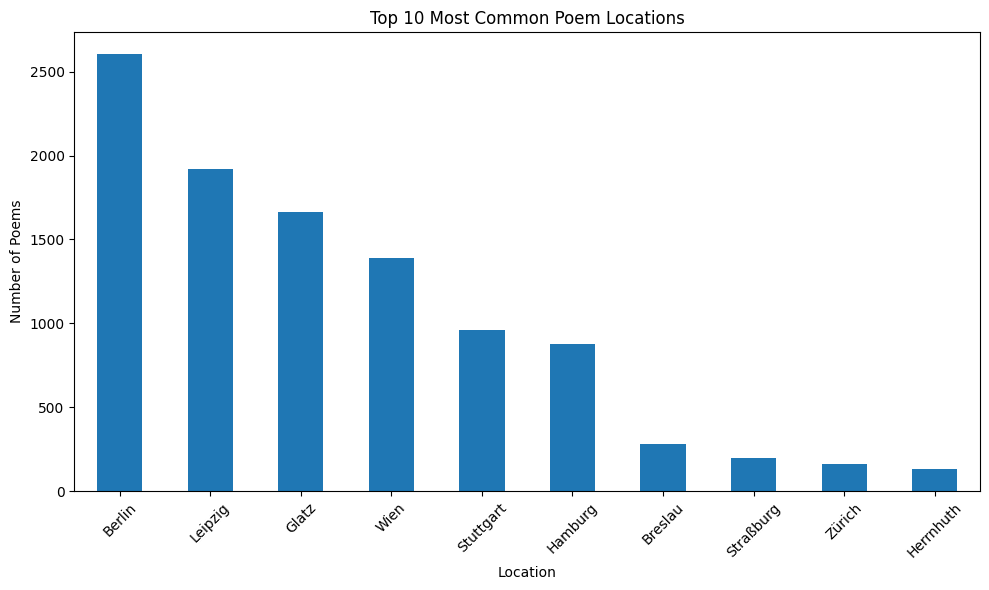

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim


df = pd.read_csv("dlk_poems_with_locations.csv") 

valid_locations = df[df["location"] != "unavailable"]

top_locations = valid_locations["location"].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar')
plt.title("Top 10 Most Common Poem Locations")
plt.xlabel("Location")
plt.ylabel("Number of Poems")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

geolocator = Nominatim(user_agent="dlk_location_mapper")
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6) 
marker_cluster = MarkerCluster().add_to(m)

for location, count in top_locations.items():
    try:
        geo = geolocator.geocode(location)
        if geo:
            folium.Marker(
                location=[geo.latitude, geo.longitude],
                popup=f"{location}: {count} poems"
            ).add_to(marker_cluster)
    except Exception as e:
        print(f"Geocoding failed for {location}: {e}")

m.save("top_poem_locations_map.html")
